In [1]:
#!rm -r AI2022MA/
#!git clone https://github.com/UmbertoJr/AI2022MA.git

# The Orienteering Problem with Time Windows

column of X:

0. index of the customer
1. x coordinate
2. y coordinate
3. lower time window
4. uppper time window
5. reward customer
6. global time constraint

adj is the distance matrix

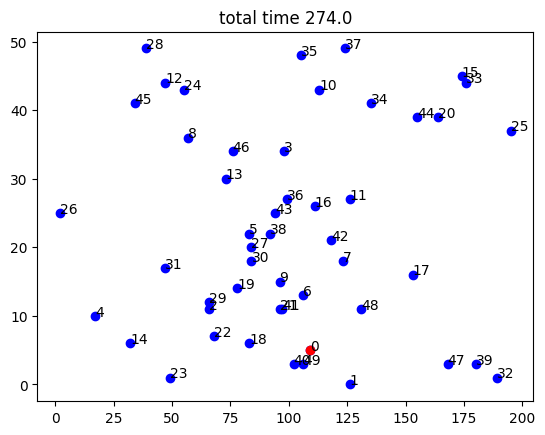

[[0.000e+00 1.090e+02 5.000e+00 0.000e+00 1.312e+03 0.000e+00 2.740e+02]
 [1.000e+00 1.260e+02 0.000e+00 2.130e+02 2.320e+02 1.700e-01 2.740e+02]
 [2.000e+00 6.600e+01 1.100e+01 7.320e+02 7.380e+02 4.000e-01 2.740e+02]
 [3.000e+00 9.800e+01 3.400e+01 1.310e+02 1.690e+02 2.900e-01 2.740e+02]
 [4.000e+00 1.700e+01 1.000e+01 6.390e+02 6.740e+02 8.400e-01 2.740e+02]]
(50, 7)
(50, 50)


In [2]:
import numpy as np
from AI2022MA.OPTW import Env, plot_instance

env = Env(from_file=True, instance_number=0)
X = np.array(env.x)
adj = env.adj
plot_instance(X)
print(X[:5])
print(X.shape)
print(adj.shape)

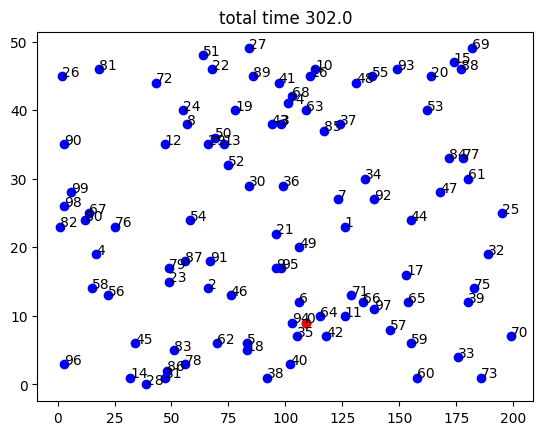

[[0.000e+00 1.090e+02 9.000e+00 0.000e+00 1.857e+03 0.000e+00 3.020e+02]
 [1.000e+00 1.260e+02 2.300e+01 2.060e+02 2.250e+02 2.000e-01 3.020e+02]
 [2.000e+00 6.600e+01 1.400e+01 4.000e+01 7.100e+01 3.800e-01 3.020e+02]
 [3.000e+00 9.800e+01 3.800e+01 1.170e+02 1.490e+02 2.800e-01 3.020e+02]
 [4.000e+00 1.700e+01 1.900e+01 6.430e+02 6.700e+02 8.200e-01 3.020e+02]]
(100, 7)
(100, 100)


In [3]:
env = Env(from_file=True, instance_number=1)
X = np.array(env.x)
adj = env.adj
plot_instance(X)
print(X[:5])
print(X.shape)
print(adj.shape)

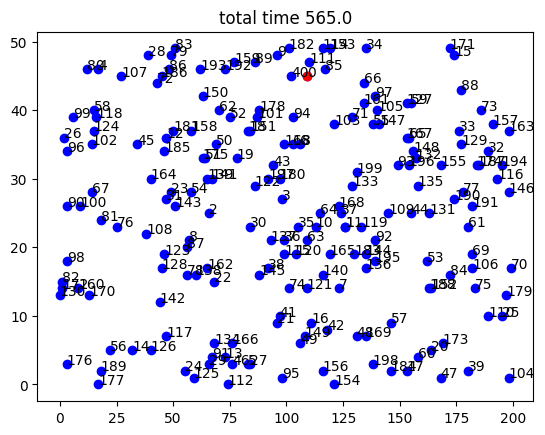

[[0.000e+00 1.090e+02 4.500e+01 0.000e+00 2.486e+03 0.000e+00 5.650e+02]
 [1.000e+00 1.260e+02 2.300e+01 1.410e+02 1.780e+02 2.500e-01 5.650e+02]
 [2.000e+00 6.600e+01 2.500e+01 8.880e+02 9.420e+02 4.100e-01 5.650e+02]
 [3.000e+00 9.800e+01 2.700e+01 2.400e+01 7.100e+01 1.900e-01 5.650e+02]
 [4.000e+00 1.700e+01 4.600e+01 6.880e+02 7.030e+02 8.000e-01 5.650e+02]]
(200, 7)
(200, 200)


In [4]:
env = Env(from_file=True, instance_number=2)
X = np.array(env.x)
adj = env.adj
plot_instance(X)
print(X[:5])
print(X.shape)
print(adj.shape)

### check if solution is feasible and print it

time window violated 225.0 
current time  233.0 
from node 1  to  49
(233.0, 0, False)


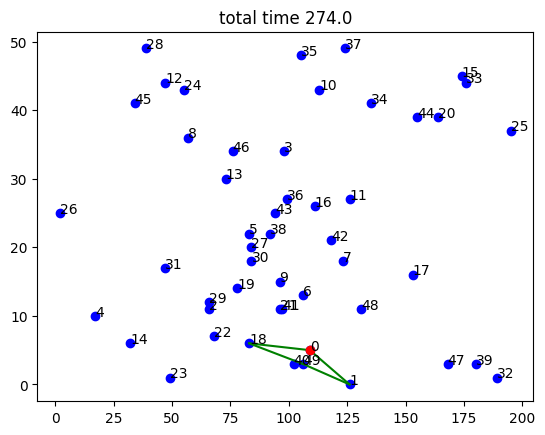

In [5]:
sol = [0, 1, 49, 18, 0]
env = Env(from_file=True, instance_number=0, verbose=True)
print(env.check_solution(sol))
plot_instance(env.x, sol)

(236.0, 0.44999999999999996, True)


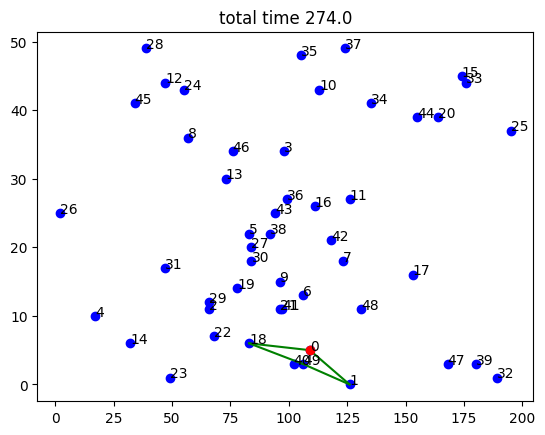

In [6]:
sol = [0, 18, 49, 1, 0]
env = Env(from_file=True, instance_number=0, verbose=True)
print(env.check_solution(sol))
plot_instance(env.x, sol)

# Monte Carlo Tree Search

### Node class for the Tree Search


In [7]:
### Node Object ###
class Node:
    def __init__(self, parent, node, travel_time, partial_path, current_reward, expandable_customers):
      self.parent = parent                                                      # parent node object 
      self.node = node                                                          # current node (or customer) index
      self.partial_path = partial_path                                          # current partial path across customers
      self.current_reward = current_reward                                      # current reward collected in the partial path
      self.num_of_visit = 0                                                     # number of visit to the current node during the MCTS 
      self.terminal = False                                                     # boolean to determine if node is terminal
      self.fully_expanded = False                                               # boolean to determine if node was expanded completely during the search
      self.estimated_reward = 0                                                 # esteem of the future reward collected thanks to the MC simulations
      self.travel_time = travel_time                                            # travel time spent with the current partial path
      self.score = None                                                         # Upper Confidence Buond score for node
      self.policy = None                                                        # IMPORTANT !!!!! Best node index according to the UCB score 
      self.expandables = copy.deepcopy(expandable_customers)                    # customers in the candidate list of the current node that are not in the current path
      self.expanded = {}
      self.reward = 0# nodes already expanded during the search
      
      if len(self.expandables) == 0:                                            
        self.fully_expanded = True
        self.terminal = True
        self.partial_path.append(0)
        self.policy = 0

    def calculateUCTscore(self, best_reward_so_far):
      # computes the Upper Confidence Bound for the Node
      c = 1 / (2 ** 0.5)
      self.score = (((self.estimated_reward/ self.num_of_visit) + self.current_reward) /
                    best_reward_so_far) + c * 2 * (2 * np.log(self.parent.num_of_visit) / 
                                                   self.num_of_visit) ** 0.5


### MCTS

In [8]:
from time import time
import copy
import numpy as np
from scipy.special import softmax
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
import math

class MCTS:
  def __init__(self, env,time_limit, initial_path):
    self.num_of_customers = env.n_nodes                                         # number of customers in the current problem
    self.env = env                                                              # environment of the problem to solve
    self.time_limit = time_limit                                                # time budget for the OPTW to solve
    self.initial_path = initial_path                                            # initial path
    self.root_node = initial_path[-1]                                           # root node index

    # saving the best tour so far, its reward and time travel
    self.best_tour_so_far = initial_path + [0]
    self.travel_time, self.max_reward, _ = self.env.check_solution(self.best_tour_so_far)

    # these operations find the promising CL for the root node
    ordered_view = {i: self.env.x[i, 5] / (self.env.x[i, 3] / self.env.x[i, 6]) for i in range(1, self.num_of_customers) if i not in initial_path 
                    and self.env.adj[self.root_node, i] + self.travel_time < self.env.x[i, 4]
                    and self.env.adj[i, 0] + self.env.adj[self.root_node, i] + self.travel_time < self.env.x[i, 6]}
    ordered_list = [k for k, v in sorted(ordered_view.items(), key=lambda item: item[1]) if k not in initial_path]

    # initialize the root node
    self.root = Node(parent=None,
                     node= self.root_node,
                     travel_time =self.travel_time,
                     partial_path=initial_path,
                     current_reward=0, 
                     expandable_customers=ordered_list)


  def treePolicy(self, node):
    """
    This function expand a node if the selected node is not being completely expanded,
    otherwise it select the best child in the Tree using the selectBestChild function
    """
    # TO DO
    # implement the tree policy
    while not node.terminal:
        if not node.fully_expanded:
            return self.expand(node)
        else:
            node = self.selectBestChild(node)
    return node
    

  def selectBestChild(self, node):
    """
    The function updates the UBC score for each child node by employing the updated max_reward
    then it returns the best child according to such score. 
    """
    best_score = 0
    best_child = None
    for index, child in node.expanded.items():
        child.calculateUCTscore(self.max_reward)
        if child.score > best_score:
            best_score = child.score
            best_child = child
            node.policy = index
    return best_child
    


  def expand(self, node):
    new_node = node.expandables.pop()                                           # it selects the most promising node from the CL 
    new_path = copy.deepcopy(node.partial_path)                                 # it copies the path and append new node to it
    new_path.append(new_node)
        
    new_reward = node.current_reward                                            # update of the reward for the new customer
    new_reward += self.env.x[new_node, 5]

    new_travel_time = max(node.travel_time + self.env.adj[node.node, new_node], # updated the travel time
                          self.env.x[new_node, 3])

    # these operations find the promising CL for the root node
    ordered_view = {i: self.env.x[i, 5]/(self.env.x[i, 3] / self.env.x[i, 6]) for i in range(1, self.num_of_customers) if i not in new_path 
                    and self.env.adj[new_node, i] + new_travel_time < self.env.x[i, 4]
                    and self.env.adj[i, 0] + self.env.adj[new_node, i] + new_travel_time < self.env.x[i, 6]}
    ordered_list = [k for k, v in sorted(ordered_view.items(), key=lambda item: item[1]) if k not in new_path]

    new_node_object = Node(parent=node,
                           node=new_node,
                           travel_time=new_travel_time,
                           partial_path=new_path,
                           current_reward=new_reward, 
                           expandable_customers=ordered_list)
    
    node.expanded[new_node] = new_node_object
    if len(node.expandables) == 0:
      node.fully_expanded = True
      
    if new_node == 0:
      new_node_object.terminal = True
      _, new_r, _ = self.env.check_solution(new_path)
      if new_r > self.max_reward:
        self.max_reward = new_r
        self.best_tour_so_far = new_path

    return new_node_object

  def defaultPolicy(self, starting_node):
    # reach the end, break condition
    if starting_node.node == 0:
      return 0

    customer = starting_node.node
    new_path = starting_node.partial_path
    travel_time = starting_node.travel_time
    while customer != 0:
      # these operations find the promising CL for the root node
      ordered_view = {i: (self.env.x[i, 5] + np.finfo(float).eps)/(self.env.x[i, 3] / self.env.x[i, 6] + np.finfo(float).eps ) for i in range(1, self.num_of_customers) if i not in new_path 
                      and self.env.adj[customer, i] + travel_time < self.env.x[i, 4] 
                      and self.env.adj[i, 0] + self.env.adj[customer, i] + travel_time < self.env.x[i, 6]}
      self.ordered_list = [k for k, v in sorted(ordered_view.items(), key=lambda item: -item[1]) if k not in new_path]
      if len(self.ordered_list) == 0:
        customer = 0
      else:
        probabilities = softmax(np.array([v for k, v in sorted(ordered_view.items(), key=lambda item: -item[1]) if k not in new_path]))
        customer = int(np.random.choice(self.ordered_list, 1, p=probabilities))
      
      new_path.append(customer)
      travel_time = max(travel_time + self.env.adj[new_path[-2], customer], self.env.x[customer, 3])
      
    _, new_r, _ = self.env.check_solution(new_path) 
    if new_r > self.max_reward:
        self.max_reward = new_r
        self.best_tour_so_far = new_path

    return new_r - starting_node.current_reward
      

  def backup(self, node, reward_esteem):
    """
    backup of the estimated reward in the MCTS
    """
    # TO DO
    while node is not None:
        node.num_of_visit += 1
        node.reward += reward_esteem
        node = node.parent

    
  

  def step(self, num_of_simulation=1):
    start = time()
    while time() - start < self.time_limit:
        current_node = self.treePolicy(self.root)
        reward_esteem = self.defaultPolicy(current_node)
        self.backup(current_node, reward_esteem)

    return self.root.policy if self.root.policy != None else 0

using seed 0 --- instance 0
(901.0, 0, False)


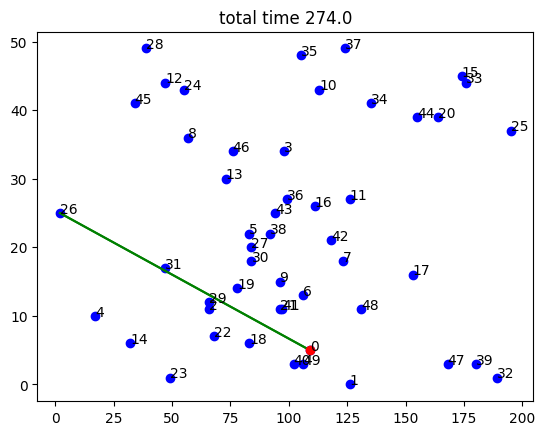

(273.0, 0.44, True)


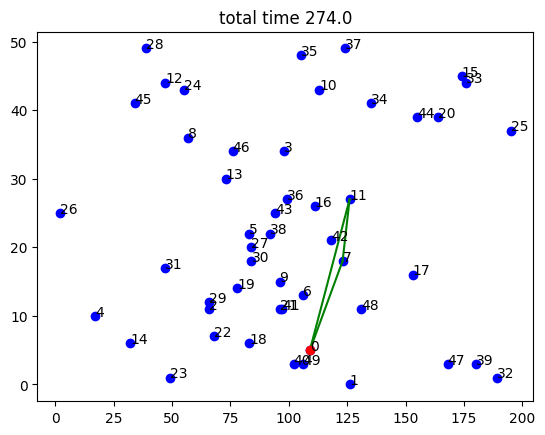

using seed 43 --- instance 0
(901.0, 0, False)


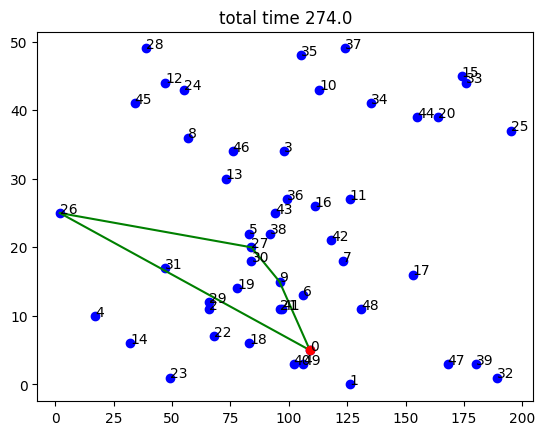

(273.0, 1.07, True)


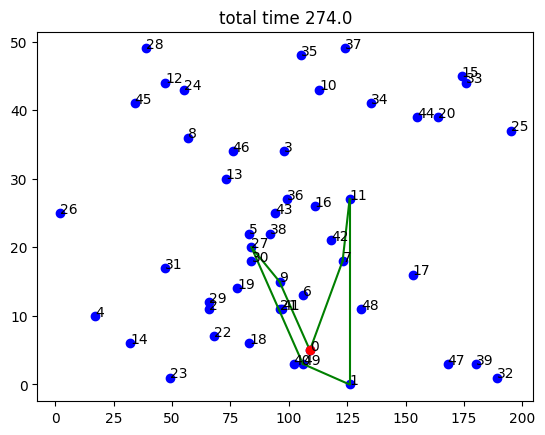

using seed 143 --- instance 0
(901.0, 0, False)


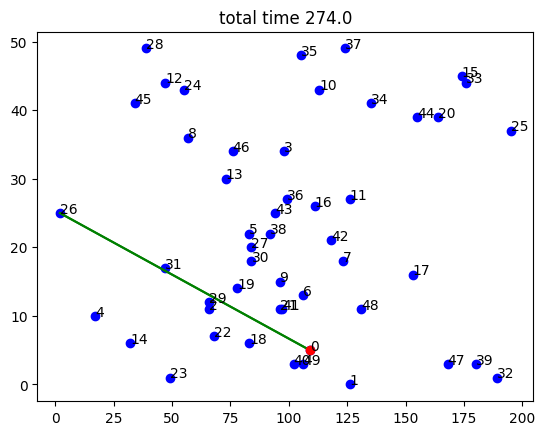

(273.0, 1.07, True)


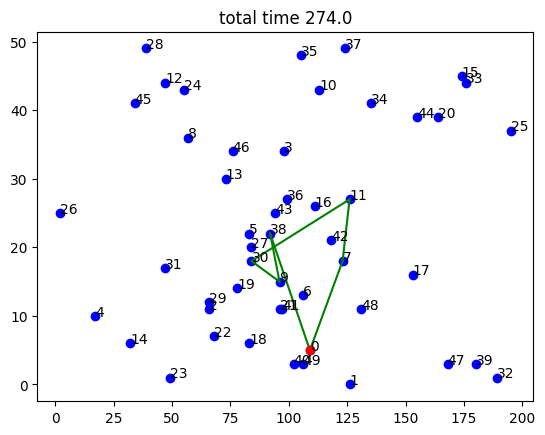

using seed 0 --- instance 1
(787.0, 0, False)


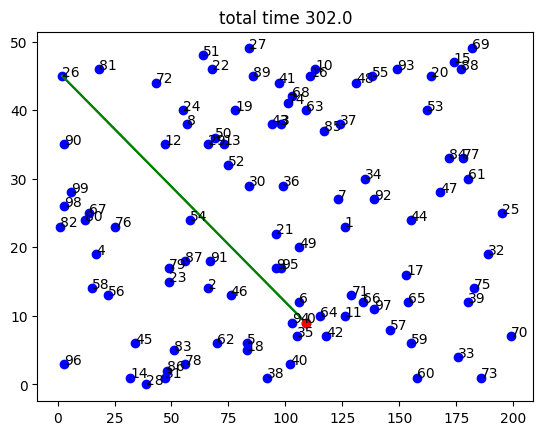

(297.0, 0.47000000000000003, True)


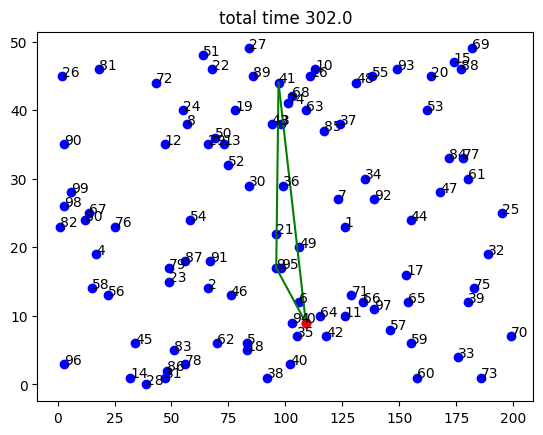

using seed 43 --- instance 1
(787.0, 0, False)


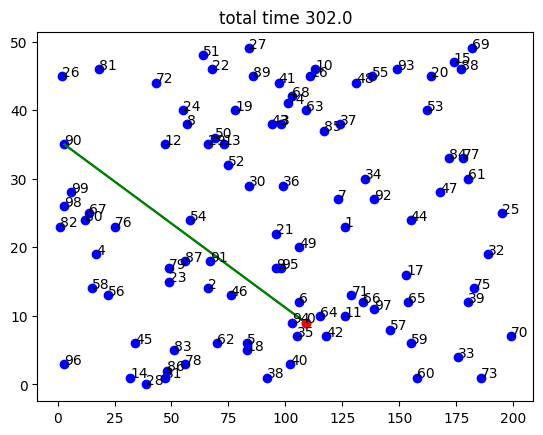

(297.0, 0.6200000000000001, True)


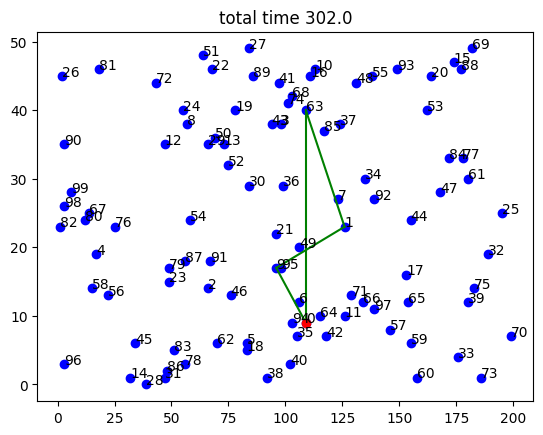

using seed 143 --- instance 1
(787.0, 0, False)


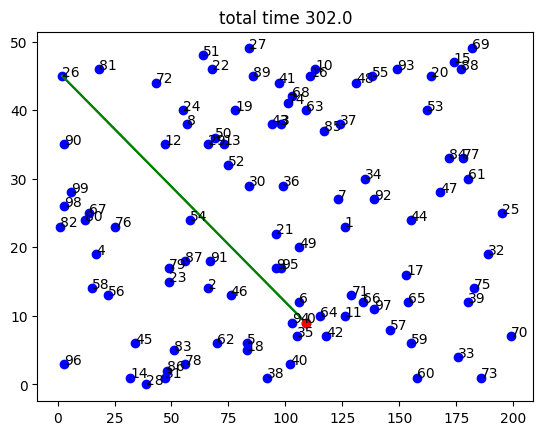

(297.0, 0.32, True)


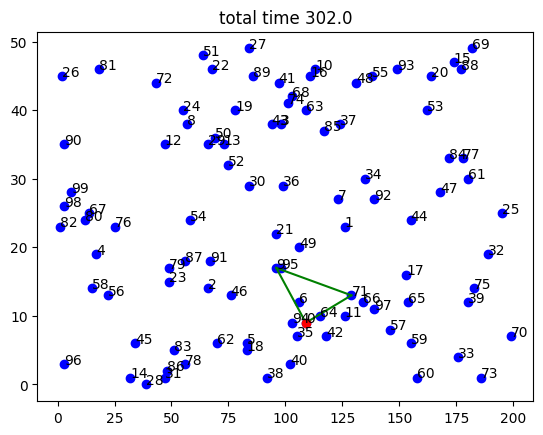

using seed 0 --- instance 2
(742.0, 0, False)


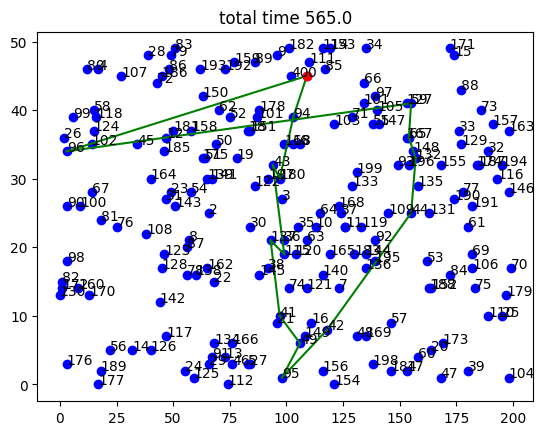

(742.0, 0, False)


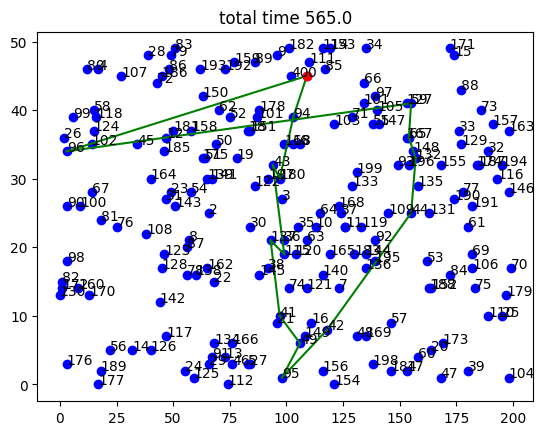

using seed 43 --- instance 2
(742.0, 0, False)


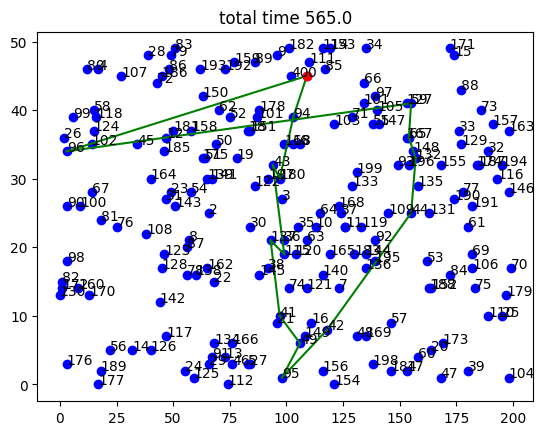

(742.0, 0, False)


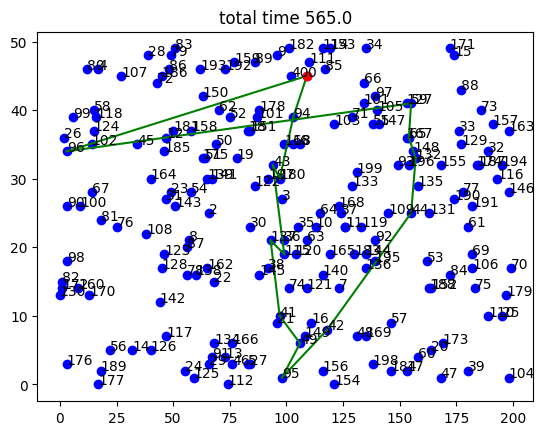

using seed 143 --- instance 2
(742.0, 0, False)


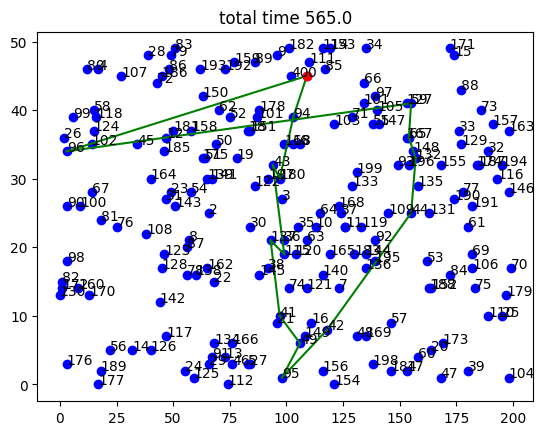

(742.0, 0, False)


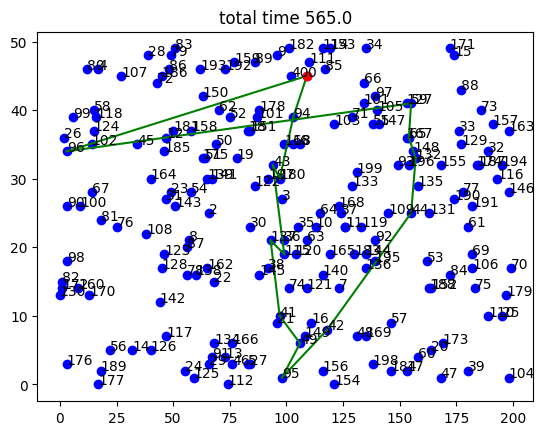

In [44]:
seeds = [0, 43, 143]
instances =[0,1, 2]
import random
import numpy as np
import matplotlib.pyplot as plt
solutions ={"instance": [], "seed":[], "best_sol":[], "tour_time":[], "reward":[]}
for instance in instances:
  
  for seed in seeds:
        
        print(f"using seed {seed} --- instance {instance}")
        np.random.seed(seed)
        random.seed(seed)
        env = Env(from_file=True, instance_number=instance)
        time_limit = 5
        sol = [0]
        best_sol = None
        best_r = 0

        while True:
          mcts = MCTS(env, time_limit, sol)
          mcts.best_tour_so_far = best_sol
          mcts.max_reward = best_r
          new_customer = mcts.step()
          # print("a new customer is", new_customer)
          sol.append(new_customer)

          if mcts.max_reward > best_r:
            best_r = mcts.max_reward
            best_sol = mcts.best_tour_so_far

          if sol[-1] == 0:
            break
        plt.title(f"seed {seed} --- instance {instance}")
        if best_sol is None:
          best_sol= sol
      
        print(env.check_solution(list(sol)))
        plot_instance(env.x, list(sol))
        print(env.check_solution(list(best_sol)))
        plot_instance(env.x, list(best_sol))
        tour_time, tour_reward, fea = env.check_solution(best_sol)
        solutions["instance"].append(instance)
        solutions["seed"].append(seed)
        solutions["best_sol"].append(best_sol)
        solutions["tour_time"].append(tour_time)
        solutions["reward"].append(tour_reward)

# Some Statistics of the Results


       instance        seed   tour_time    reward
count  9.000000    9.000000    9.000000  9.000000
mean   1.000000   62.000000  437.333333  0.443333
std    0.866025   63.539358  228.736202  0.421634
min    0.000000    0.000000  273.000000  0.000000
25%    0.000000    0.000000  273.000000  0.000000
50%    1.000000   43.000000  297.000000  0.440000
75%    2.000000  143.000000  742.000000  0.620000
max    2.000000  143.000000  742.000000  1.070000
['instance 0 with seed 0', 'instance 0 with seed 43', 'instance 0 with seed 143', 'instance 1 with seed 0', 'instance 1 with seed 43', 'instance 1 with seed 143', 'instance 2 with seed 0', 'instance 2 with seed 43', 'instance 2 with seed 143']


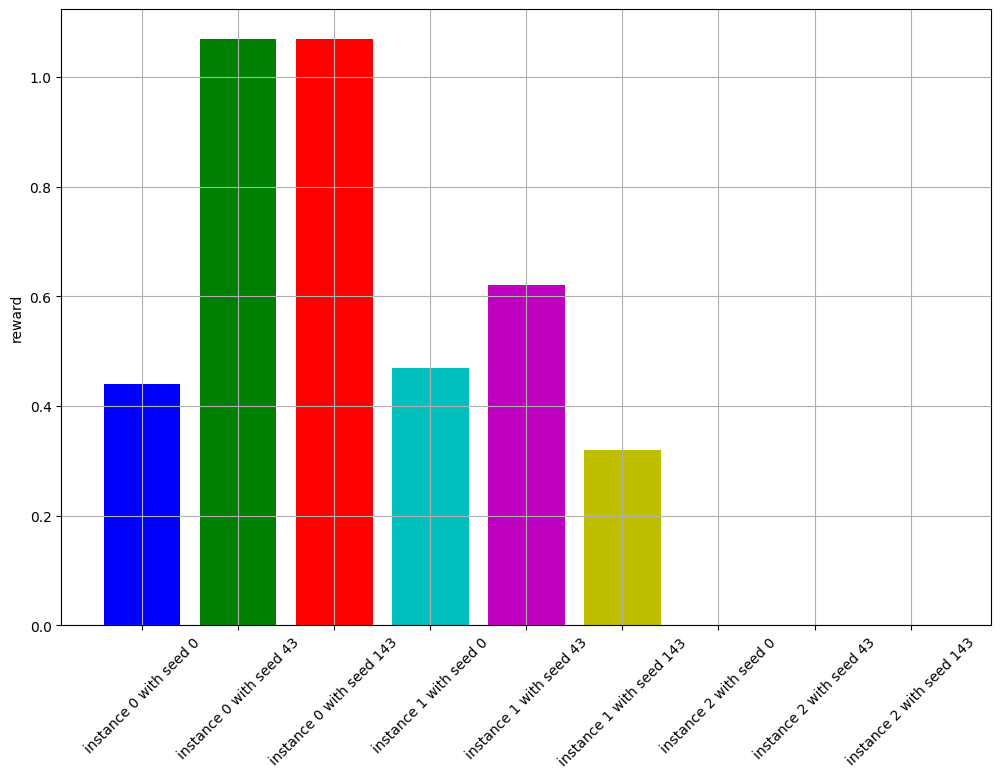

In [71]:
import pandas as pd
data_frame = pd.DataFrame(solutions)
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
print(data_frame.describe())
import matplotlib.pyplot as plt
x = [
    f"instance {str(i)} with seed {str(j)}"
    for i, j in zip(solutions["instance"], solutions["seed"])
]
#print(x)
x_num_list = list(range(9))
plt.figure(figsize=(12,8))
plt.bar(x_num_list, solutions["reward"], color=colors)
plt.xticks(x_num_list, x, rotation=45)
#plt.xlabel(x)
plt.grid()
plt.ylabel("reward")
from scipy.interpolate import UnivariateSpline
spline = UnivariateSpline(x_num_list, solutions["reward"], k=5)
x_smooth = np.linspace(x_num_list[0], x_num_list[-1], 1000)
y_smooth = spline(x_smooth)

# Plot the smooth curve
#plt.plot(x_smooth, y_smooth, 'r-')
# Generate a smooth curve using the spline

#plt.xticks(list(range(len(solutions["instance"]))))
#data_frame.plot(x='instance', y='reward', kind='scatter')	
plt.show()

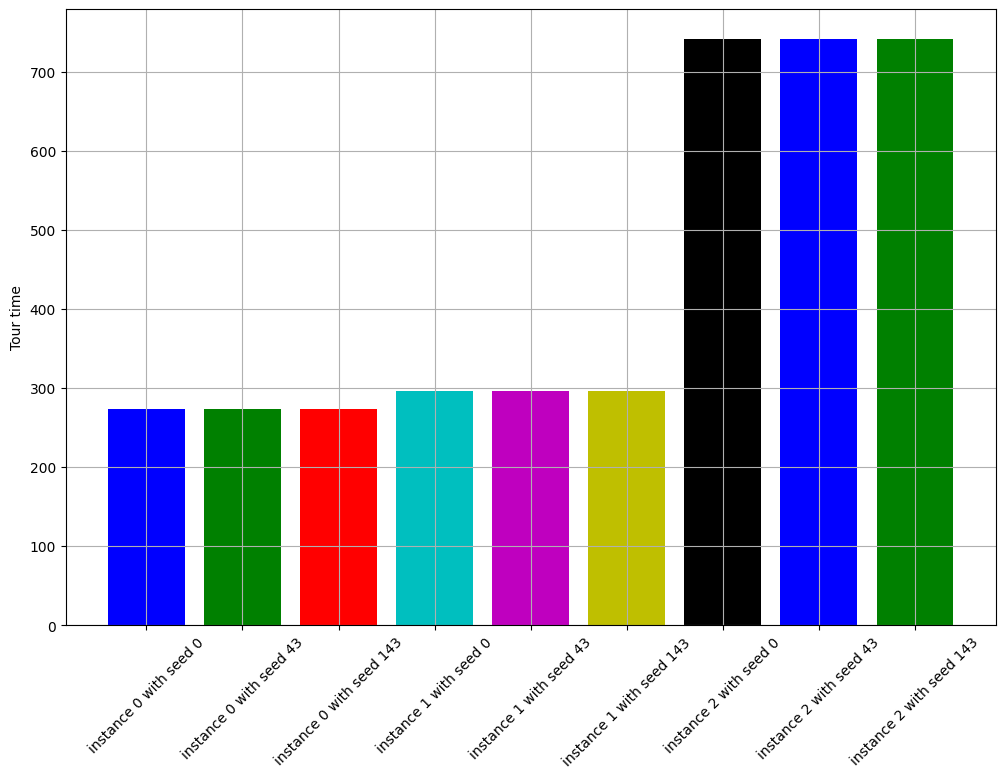

In [70]:
plt.figure(figsize=(12,8))
plt.bar(x, solutions["tour_time"], color=colors)
plt.xticks(list(range(len(solutions["tour_time"]))), x, rotation=45)
#plt.xlabel(x)
plt.grid()
plt.ylabel("Tour time")
spline = UnivariateSpline(x_num_list, solutions["tour_time"], k=1)
x_smooth = np.linspace(x_num_list[0], x_num_list[-1], 1000)
y_smooth = spline(x_smooth)

# Plot the smooth curve
#plt.plot(x_smooth, y_smooth, 'r-')
#plt.plot(x, solutions["tour_time"], 'r-', smooth=True)
#plt.xticks(list(range(len(solutions["instance"]))))
#data_frame.plot(x='instance', y='reward', kind='scatter')	
plt.show()

## Considerations about the results

It seems that for the first and the second instances, the results make sense according to their rewards and tour length. In contrast, for the third instance there are time violations. In fact, the function "$check\_solution$" returns zero for the rewards. Indeed, the plot above does not show anything for the rewars about the solutions for the third instance. 

# Creating my own MCTS

In [ ]:
"""env = Env(from_file=True, instance_number=1)
time_limit = 5
sol = [0]
best_sol = None
best_r = 0
while True:
  mcts = MCTS(env, time_limit, sol)
  mcts.best_tour_so_far = best_sol
  mcts.max_reward = best_r
  new_customer = mcts.step()
  # print("a new customer is", new_customer)
  sol.append(new_customer)
  if mcts.max_reward > best_r:
    best_r = mcts.max_reward
    best_sol = mcts.best_tour_so_far
  if sol[-1] == 0:
    break
if best_sol is None:
      best_sol= sol
print(env.check_solution(sol))
plot_instance(env.x, sol)
print(env.check_solution(best_sol))
plot_instance(env.x, best_sol)"""

In [ ]:
"""env = Env(from_file=True, instance_number=2)
time_limit = 5
sol = [0]
best_sol = None
best_r = 0
while True:
  mcts = MCTS(env, time_limit, sol)
  mcts.best_tour_so_far = best_sol
  mcts.max_reward = best_r
  new_customer = mcts.step()
  sol.append(new_customer)
  if mcts.max_reward > best_r:
    best_r = mcts.max_reward
    best_sol = mcts.best_tour_so_far
  if sol[-1] == 0:
    break
if best_sol is None:
      best_sol= sol
      
print(env.check_solution(list(sol)))
plot_instance(env.x, list(sol))
print(env.check_solution(list(best_sol)))
plot_instance(env.x, list(best_sol))"""

In [ ]:
"""import copy
import numpy as np

class myMCTS:
  def __init__(self,env, root, time_limit, reward_limit):
    self.root = root 
    self.env = env# root node object
    self.time_limit = time_limit                    # time limit for MCTS search
    self.reward_limit = reward_limit                # reward limit for MCTS search
    self.best_reward_so_far = float('-inf')         # best reward found so far in the search
    
  def search(self):
    start_time = time.time()                       # start time of MCTS search
    while time.time() - start_time < self.time_limit:  # search until time limit is reached
      # Selection
      node = self.root
      while not node.terminal:
        if not node.fully_expanded:
          break
        node = self.best_child(node, c=1 / (2 ** 0.5))  # choose node with highest UCB score
      
      # Expansion
      if not node.fully_expanded:
        expandable_nodes = node.expandables
        if len(expandable_nodes) > 0:
          new_node = self.expand(node, expandable_nodes)
          node.expanded[new_node.node] = new_node
          if len(expandable_nodes) == 1:
            node.fully_expanded = True
          node = new_node
        else:
          node.fully_expanded = True
          node.terminal = True
      
      # Simulation
      reward = self.simulate(node)
      
      # Backpropagation
      self.backpropagate(node, reward)
      
    # choose best child of root node as the final policy
    self.root.policy = self.best_child(self.root, c=0).node
    return self.root.policy
      
  def best_child(self, node, c):
    """
    #Returns the child node with the highest UCB score.
    """
    best_score = float('-inf')
    best_child = None
    for child in node.expanded.values():
      score = child.calculateUCTscore(self.best_reward_so_far) + c * np.random.random()
      if score > best_score:
        best_score = score
        best_child = child
    return best_child
  
  def expand(self, node, expandable_nodes):
    """
    #Expands the current node by creating a new child node for each expandable node.
    """
    return Node(
        parent=node,
        node=expandable_nodes[0],
        travel_time=node.travel_time,
        partial_path=copy.deepcopy(node.partial_path),
        current_reward=node.current_reward,
        expandable_customers=node.expandables,
    )
  
  def simulate(self, node):
          """
      #Simulates the reward collected from the current node to the end of the path.
      """
          current_node = node
          while not current_node.terminal:
              expandable_nodes = current_node.expandables
              if len(expandable_nodes) > 0:
                  new_node = self.expand(current_node, expandable_nodes)
                  current_node.expanded[new_node.node] = new_node
                  if len(expandable_nodes) == 1:
                      current_node.fully_expanded = True
                      current_node = new_node
              else:
                  current_node.fully_expanded = True
                  current_node.terminal = True
          return current_node.current_reward
      
  def backpropagate(self, node, reward):
      """
      #Updates the reward and number of visits for each node in the path from the current node to the root.
      """
      current_node = node
      while current_node is not None:
        current_node.num_of_visit += 1
        current_node.estimated_reward += reward
        if reward > self.best_reward_so_far:
          self.best_reward_so_far = reward
        current_node = current_node.parent"""



In [ ]:
"""env = Env(from_file=True, instance_number=0)
time_limit = 5
reward_limit = 100  # change this to the desired reward limit
sol = [0]
best_sol = None
best_r = 0
root = Node(parent=None,
                     node= mcts.root,
                     travel_time =mcts.travel_time,
                     partial_path=mcts.initial_path,
                     current_reward=0, 
                     expandable_customers=mcts.ordered_list)
import time
while True:
  mcts = myMCTS(env, root, time_limit, reward_limit)  # update the third argument to the desired reward limit
  mcts.best_tour_so_far = best_sol
  mcts.max_reward = best_r
  new_customer = mcts.search()
  sol.append(new_customer)
  if mcts.max_reward > best_r:
    best_r = mcts.max_reward
    best_sol = mcts.best_tour_so_far
  if sol[-1] == 0:
    break"""

